<a href="https://colab.research.google.com/github/toygarr/image-processing/blob/main/project/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import copy
import random
from PIL import Image
import shutil
from urllib.request import urlretrieve
import os
import cv2
import time

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import torchvision
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2

import glob
from tqdm import tqdm

from torchvision.datasets import OxfordIIITPet
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
from torchvision import transforms
import torchvision.transforms as tt

cudnn.benchmark = True

# Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import itertools


    Documentation can be found below to understand how data set can be constructed and retrieved in different ways:
    * https://pytorch.org/vision/stable/_modules/torchvision/datasets/oxford_iiit_pet.html#OxfordIIITPet 
    * https://pytorch.org/vision/stable/generated/torchvision.datasets.OxfordIIITPet.html#torchvision.datasets.OxfordIIITPet
    * https://discuss.pytorch.org/t/how-to-split-dataset-into-test-and-validation-sets/33987
    * https://blog.paperspace.com/dataloaders-abstractions-pytorch/
    * https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/
    * https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet




# About Data

They have created a 37 category pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.

- https://www.robots.ox.ac.uk/~vgg/data/pets/

![image.png](attachment:37e0bc3a-5e34-4fe1-bf69-c7a563b8454f.png)

# Prepare Data

    Here, first I tried prepared methods by using PyTorch datasets to retrieve data.
    However, there is an important problem that PyTorch or TensorFlow do not allow create custom train-test-val. Moreover, it is more complicated to handle with data retrieved by any framework. 
    
    Original dataset tools retrieve data with splitting as %50 training %50 test which we do not prefer almost any case. I will be splitting as %80 trainval %20 test, then trainval -> %70 training and %30 validation.

    Therefore, I manually handled and splitted the data. The entire preparation can be found below.

In [ ]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Dataset already exists on the disk. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)


def merge_trainval_test(filepath):
    """
        #   Image CLASS-ID SPECIES BREED ID
        #   ID: 1:37 Class ids
        #   SPECIES: 1:Cat 2:Dog
        #   BREED ID: 1-25:Cat 1:12:Dog
        #   All images with 1st letter as captial are cat images
        #   images with small first letter are dog images
    """
    merge_dir = os.path.dirname(os.path.abspath(f'{filepath}/annotations/data.txt'))
    #if os.path.exists(merge_dir):
    #    print("Merged data is already exists on the disk. Skipping creating new data file.")
    #    return
    df = pd.read_csv(f"{filepath}/annotations/trainval.txt", sep=" ", 
                     names=["Image", "ID", "SPECIES", "BREED ID"])
    df2 = pd.read_csv(f"{filepath}/annotations/test.txt", sep=" ",
                      names=["Image", "ID", "SPECIES", "BREED ID"])
    frame = [df, df2]
    df = pd.concat(frame)
    df.reset_index(drop=True)
    df.to_csv(f'{filepath}/annotations/data.txt', index=None, sep=' ')
    print("Merged data is created.")



## Retrieving Data
**For below implementation, you can simply adjust the path for Google Drive and also use Colab or local.**

In [ ]:
dataset_directory = os.path.join("./dataset")
os.mkdir(dataset_directory)

In [ ]:
filepath = os.path.join(dataset_directory, "images.tar.gz")
download_url(
    url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz", filepath=filepath,
)
extract_archive(filepath)

images.tar.gz: 100%|██████████| 755M/755M [00:37<00:00, 21.2MB/s]    


In [ ]:
filepath = os.path.join(dataset_directory, "annotations.tar.gz")
download_url(
    url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz", filepath=filepath,
)
extract_archive(filepath)

annotations.tar.gz: 100%|██████████| 18.3M/18.3M [00:03<00:00, 6.12MB/s]


In [ ]:
filepath = os.path.join(dataset_directory)
merge_trainval_test(filepath)

Merged data is created.


In [ ]:
dataset = pd.read_csv(f"{filepath}/annotations/data.txt", sep=" ")
dataset

,Image,ID,SPECIES,BREED ID
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1
...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25
7345,yorkshire_terrier_97,37,2,25
7346,yorkshire_terrier_98,37,2,25
7347,yorkshire_terrier_99,37,2,25


    Now, we can be able to create any size of train test val also with stratifying labels.
    custom data.txt file includes all information we need.

    #   Image CLASS-ID SPECIES BREED ID
    #   ID: 1:37 Class ids
    #   SPECIES: 1:Cat 2:Dog
    #   BREED ID: 1-25:Cat 1:12:Dog
    #   All images with 1st letter as captial are cat images
    #   images with small first letter are dog images


    We need to retrieve which id is belong to which animal, manually.
    After we create a map for indexes, it will be used for mapping idx to class.

In [ ]:
image_ids = []
labels = []
with open(f"{filepath}/annotations/trainval.txt") as file:
    for line in file:
        image_id, label, *_ = line.strip().split()
        image_ids.append(image_id)
        labels.append(int(label)-1)

classes = [
    " ".join(part.title() for part in raw_cls.split("_"))
    for raw_cls, _ in sorted(
        {(image_id.rsplit("_", 1)[0], label) for image_id, label in zip(image_ids, labels)},
        key=lambda image_id_and_label: image_id_and_label[1],
    )
    ]

idx_to_class = dict(zip(range(len(classes)), classes))

In [ ]:
idx_to_class

{0: 'Abyssinian',
 1: 'American Bulldog',
 2: 'American Pit Bull Terrier',
 3: 'Basset Hound',
 4: 'Beagle',
 5: 'Bengal',
 6: 'Birman',
 7: 'Bombay',
 8: 'Boxer',
 9: 'British Shorthair',
 10: 'Chihuahua',
 11: 'Egyptian Mau',
 12: 'English Cocker Spaniel',
 13: 'English Setter',
 14: 'German Shorthaired',
 15: 'Great Pyrenees',
 16: 'Havanese',
 17: 'Japanese Chin',
 18: 'Keeshond',
 19: 'Leonberger',
 20: 'Maine Coon',
 21: 'Miniature Pinscher',
 22: 'Newfoundland',
 23: 'Persian',
 24: 'Pomeranian',
 25: 'Pug',
 26: 'Ragdoll',
 27: 'Russian Blue',
 28: 'Saint Bernard',
 29: 'Samoyed',
 30: 'Scottish Terrier',
 31: 'Shiba Inu',
 32: 'Siamese',
 33: 'Sphynx',
 34: 'Staffordshire Bull Terrier',
 35: 'Wheaten Terrier',
 36: 'Yorkshire Terrier'}

### (Note: the original data is between 1-37, not 0-36, we must set these values to the range 0-36 to use the dictionary)
### ID is between 1-37 but we need 0-36

In [ ]:
dataset['nID'] = dataset['ID'] - 1

In [ ]:
decode_map = idx_to_class
def decode_label(label):
    return decode_map[int(label)]

In [ ]:
dataset["class"] = dataset["nID"].apply(lambda x: decode_label(x))

In [ ]:
dataset

,Image,ID,SPECIES,BREED ID,nID,class
0,Abyssinian_100,1,1,1,0,Abyssinian
1,Abyssinian_101,1,1,1,0,Abyssinian
2,Abyssinian_102,1,1,1,0,Abyssinian
3,Abyssinian_103,1,1,1,0,Abyssinian
4,Abyssinian_104,1,1,1,0,Abyssinian
...,...,...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25,36,Yorkshire Terrier
7345,yorkshire_terrier_97,37,2,25,36,Yorkshire Terrier
7346,yorkshire_terrier_98,37,2,25,36,Yorkshire Terrier
7347,yorkshire_terrier_99,37,2,25,36,Yorkshire Terrier


    Now we have everything we need
    - string class
    - id
    - species
    - breed
    - image id

In [ ]:
dataset['class'].value_counts()

Yorkshire Terrier             200
Samoyed                       200
Russian Blue                  200
Ragdoll                       200
Pug                           200
Pomeranian                    200
Persian                       200
Miniature Pinscher            200
Maine Coon                    200
Leonberger                    200
American Bulldog              200
Japanese Chin                 200
Havanese                      200
Great Pyrenees                200
German Shorthaired            200
English Setter                200
Shiba Inu                     200
Chihuahua                     200
British Shorthair             200
Sphynx                        200
Wheaten Terrier               200
Birman                        200
Bengal                        200
Beagle                        200
Basset Hound                  200
American Pit Bull Terrier     200
Saint Bernard                 200
Siamese                       199
Scottish Terrier              199
Keeshond      


    trainval -> image names of train and validation, x_test -> image names of test
    y_trainval -> image class, y_test -> image class

    x_train, x_val -> image names of train and validation
    y_trainval, y_test -> image class


### Using stratify is an important concept to maintain label distribution while splitting.

In [ ]:
from sklearn.model_selection import train_test_split

y = dataset['class']
x = dataset['Image']

trainval, x_test, y_trainval, y_test = train_test_split(x, y,
                                                        stratify=y, 
                                                        test_size=0.2,
                                                        random_state=42)

x_train, x_val, y_train, y_val = train_test_split(  trainval, y_trainval,
                                                    stratify=y_trainval, 
                                                    test_size=0.3,
                                                    random_state=42)

    My custom data set contains:
    - training: 4115 samples
    - validation: 1764 samples
    - test: 1470 samples

In [ ]:
from IPython. core. interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
df_train = pd.DataFrame(y_train)
print("About data:")
df_train.describe()

print("\n****** Class Distribution ******")
df_train['class'].value_counts()

About data:


,class
count,4115
unique,37
top,Shiba Inu
freq,112



****** Class Distribution ******


Shiba Inu                     112
Japanese Chin                 112
Saint Bernard                 112
Maine Coon                    112
Miniature Pinscher            112
Chihuahua                     112
English Setter                112
British Shorthair             112
Samoyed                       112
Wheaten Terrier               112
Bengal                        112
Basset Hound                  112
Pomeranian                    112
American Bulldog              112
German Shorthaired            112
Havanese                      112
Sphynx                        112
Leonberger                    112
Great Pyrenees                112
Yorkshire Terrier             112
Russian Blue                  112
Persian                       112
American Pit Bull Terrier     112
Pug                           112
Beagle                        112
Birman                        112
Ragdoll                       112
Abyssinian                    111
Keeshond                      111
Boxer         

In [ ]:
df_val = pd.DataFrame(y_val)
print("About data:")
df_val.describe()

print("\n****** Class Distribution ******")
df_val['class'].value_counts()

About data:


,class
count,1764
unique,37
top,Abyssinian
freq,48



****** Class Distribution ******


Abyssinian                    48
Ragdoll                       48
British Shorthair             48
Russian Blue                  48
Chihuahua                     48
Japanese Chin                 48
Havanese                      48
Bengal                        48
Boxer                         48
Keeshond                      48
Persian                       48
Miniature Pinscher            48
Birman                        48
English Setter                48
Yorkshire Terrier             48
German Shorthaired            48
Pomeranian                    48
Pug                           48
Saint Bernard                 48
American Bulldog              48
Wheaten Terrier               48
Sphynx                        48
Scottish Terrier              48
Great Pyrenees                48
Siamese                       48
Basset Hound                  48
American Pit Bull Terrier     48
Maine Coon                    48
Shiba Inu                     48
Beagle                        48
Leonberger

In [ ]:
df_test = pd.DataFrame(y_test)
print("About data:")
df_test.describe()

print("\n****** Class Distribution ******")
df_test['class'].value_counts()

About data:


,class
count,1470
unique,37
top,Sphynx
freq,40



****** Class Distribution ******


Sphynx                        40
American Bulldog              40
Siamese                       40
Chihuahua                     40
American Pit Bull Terrier     40
Basset Hound                  40
Wheaten Terrier               40
Scottish Terrier              40
Persian                       40
Leonberger                    40
Keeshond                      40
Maine Coon                    40
Bengal                        40
Havanese                      40
Great Pyrenees                40
Japanese Chin                 40
Pug                           40
English Setter                40
Samoyed                       40
German Shorthaired            40
Beagle                        40
Miniature Pinscher            40
British Shorthair             40
Russian Blue                  40
Yorkshire Terrier             40
Shiba Inu                     40
Saint Bernard                 40
Birman                        40
Pomeranian                    40
Boxer                         40
Ragdoll   

End of data preperation
------

-------

# Data Analysis

In [ ]:
root_directory = os.path.join(dataset_directory)
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "annotations", "trimaps")

train_images_filenames = x_train.reset_index(drop=True)
val_images_filenames = x_val.reset_index(drop=True)
test_images_filenames = x_test.reset_index(drop=True)

In [ ]:
print(" train size: ", len(train_images_filenames),"\n",
      "val size: ", len(val_images_filenames),"\n", 
      "test size: ", len(test_images_filenames))

 train size:  4115 
 val size:  1764 
 test size:  1470


In [ ]:
def preprocess_mask(mask):
    mask = np.float32(mask) / 255
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask

In [ ]:
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = Image.open(os.path.join(images_directory, f'{image_filename}.jpg')).convert('RGB')

        mask = Image.open(os.path.join(masks_directory, f'{image_filename}.png'))
        mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

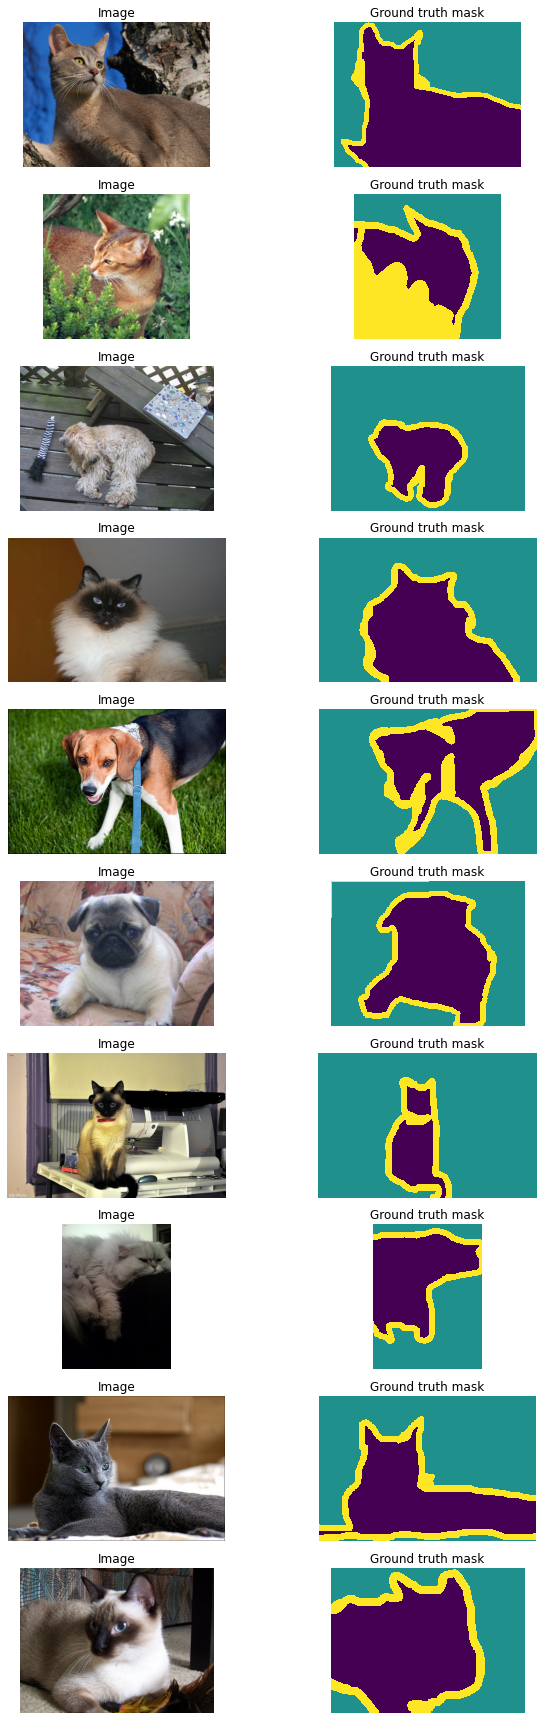

In [ ]:
display_image_grid(train_images_filenames[:10], images_directory, masks_directory)

### This section is an example of what happens if you prefer to augment data. I will not use augmentations while training.

In [ ]:
example_image_filename = train_images_filenames[10]
image = plt.imread(os.path.join(images_directory, f'{example_image_filename}.jpg'))

resized_image = A.resize(image, height=256, width=256)
padded_image = A.pad(image, min_height=512, min_width=512)
padded_constant_image = A.pad(image, min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT)
cropped_image = A.center_crop(image, crop_height=256, crop_width=256)

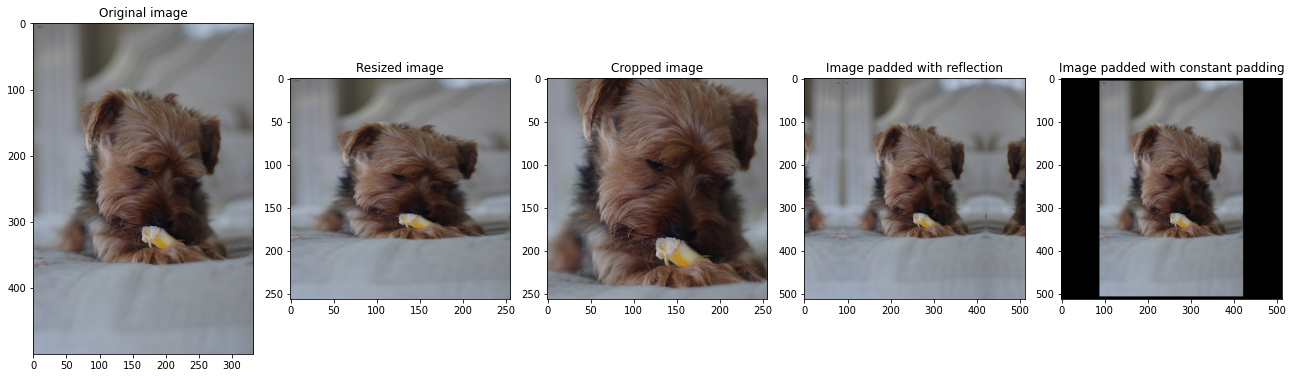

In [ ]:
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"
figure, ax = plt.subplots(nrows=1, ncols=5, figsize=(18, 10))
ax.ravel()[0].imshow(image)
ax.ravel()[0].set_title("Original image")
ax.ravel()[1].imshow(resized_image)
ax.ravel()[1].set_title("Resized image")
ax.ravel()[2].imshow(cropped_image)
ax.ravel()[2].set_title("Cropped image")
ax.ravel()[3].imshow(padded_image)
ax.ravel()[3].set_title("Image padded with reflection")
ax.ravel()[4].imshow(padded_constant_image)
ax.ravel()[4].set_title("Image padded with constant padding")
plt.tight_layout()
plt.show()

# End of data analysis
----

# Create Custom DataLoader

In [ ]:
#train_images_filenames = train_images_filenames.apply(lambda x:x + '.jpg')
#val_images_filenames = val_images_filenames.apply(lambda x:x + '.jpg')
from PIL import Image

class OxfordPetDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None, transform_mask=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames.loc[idx] + '.jpg' 
        image = Image.open(os.path.join(self.images_directory, image_filename)).convert('RGB')
        mask = Image.open(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")))
        #mask = preprocess_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image)
            transformed_m = self.transform_mask(mask)
            image = transformed
            mask = transformed_m
        return image, mask

In [ ]:
train_transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
target_transform = transforms.Compose([transforms.PILToTensor(),     
                                       transforms.Resize((256, 256)),     
                                       transforms.Lambda(lambda x: (x-1).squeeze().type(torch.LongTensor)) ])

In [ ]:
train_dataset = OxfordPetDataset(train_images_filenames, 
                                 images_directory, 
                                 masks_directory, 
                                 transform=train_transform, 
                                 transform_mask=target_transform)


val_dataset = OxfordPetDataset(val_images_filenames,
                               images_directory,
                               masks_directory,
                               transform=train_transform,
                               transform_mask=target_transform)

In [ ]:
torch.cuda.is_available()

True

### If you are going to augment the data, you can use this part to check that the masks have changed correctly. Otherwise, just ignore. 

![image.png](attachment:dd5cd375-bc95-461c-974b-3a4e80f9991d.png)

In [ ]:
#def visualize_augmentations(dataset, idx=0, samples=5):
#    dataset = copy.deepcopy(dataset)
#    dataset.transform = .Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
#    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
#    for i in range(samples):
#        image, mask = dataset[idx]
        #print(mask.shape)
#        ax[i, 0].imshow(image)
#        ax[i, 1].imshow(mask, interpolation="nearest")
#        ax[i, 0].set_title("Augmented image")
#        ax[i, 1].set_title("Augmented mask")
#        ax[i, 0].set_axis_off()
#        ax[i, 1].set_axis_off()
#    plt.tight_layout()
#    plt.show()

In [ ]:
#random.seed(42)
#visualize_augmentations(train_dataset, idx=128)

# LinkNet

In [ ]:
from torchvision.models import resnet
nonlinearity = nn.ReLU

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, n_filters):
        super().__init__()

        # B, C, H, W -> B, C/4, H, W
        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nonlinearity(inplace=True)

        # B, C/4, H, W -> B, C/4, H, W
        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, 3,
                                          stride=2, padding=1, output_padding=1)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)
        self.relu2 = nonlinearity(inplace=True)

        # B, C/4, H, W -> B, C, H, W
        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nonlinearity(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        return x


class LinkNet(nn.Module):
    def __init__(self, num_classes, num_channels=3, encoder='resnet34'):
        super().__init__()
        assert encoder in ['resnet18', 'resnet34']

        filters = [64, 128, 256, 512]
        
        res = resnet.resnet34(pretrained=True)
        
        self.firstconv = res.conv1
        self.firstbn = res.bn1
        self.firstrelu = res.relu
        self.firstmaxpool = res.maxpool
        self.encoder1 = res.layer1
        self.encoder2 = res.layer2
        self.encoder3 = res.layer3
        self.encoder4 = res.layer4

        # Decoder
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 3,
                                               stride=2)
        self.finalrelu1 = nonlinearity(inplace=True)
        self.finalconv2 = nn.Conv2d(32, 32, 3)
        self.finalrelu2 = nonlinearity(inplace=True)
        self.finalconv3 = nn.Conv2d(32, num_classes, 2, padding=1)

    def forward(self, x):
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Decoder with Skip Connections
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # Final Classification
        x = self.finaldeconv1(d1)
        x = self.finalrelu1(x)
        x = self.finalconv2(x)
        x = self.finalrelu2(x)
        x = self.finalconv3(x)
        return x

- https://stackoverflow.com/questions/70279287/runtimeerror-expected-scalar-type-long-but-found-float-pytorch<br/>
This error was a nightmare, solution is here...
- https://discuss.pytorch.org/t/target-size-torch-size-3-3-256-256-must-be-the-same-as-input-size-torch-size-3-65536/149359<br/>
Also this error. Mine was (batchsize, 3, 256, 256) vs (batchsize, 256, 256). The problem was all about using wrong loss function.

I solved many problems while coding, but couldn't find all to refer.<br/> 
**Writing code from scratch might has annoying process to figure out what can be the problems.** 

    import torchvision
    from torchview import draw_graph

    model_graph = draw_graph(model, input_size=(1,3,256,256), expand_nested=True)
    model_graph.visual_graph

In [ ]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()])


def create_model(params):
    model = LinkNet(3)
    model = model.to(params["device"])
    return model


from torchmetrics.functional import dice

def fit(model, train_dataset, val_dataset, params):
    torch.cuda.empty_cache()
    criterion = nn.CrossEntropyLoss().to(params['device'])
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
 
    history = pd.DataFrame(columns=['end_loss', 'end_correct', 'end_dice', 'end_val_loss', 'end_val_correct', 'end_val_dice'])

    for epoch in range(1, params["epochs"] + 1):
        
        loss = 0
        correct = 0
        dice_score = 0
        train_loss = 0
        train_correct = 0
        train_dice_score = 0
        val_loss = 0
        val_correct = 0
        val_dice_score = 0
        
        #Train
        metric_monitor = MetricMonitor()
        stream = tqdm(train_loader)
        for i, (images, targets) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            targets = targets.to(params["device"], non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, targets)
            metric_monitor.update("Loss", loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            stream.set_description("Epoch: {epoch}. Train.  {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
                
        train_loss = loss.item()
        _, pred = torch.max(outputs, 1)
        correct = torch.mean((pred == targets).type(torch.float64))
        dice_score = dice(pred, targets, average='macro', num_classes=3)
        print("-> Epoch: {:.1f}. Train.  Dice Score: {:.3f}  Accuracy: {:.3f}".format(epoch, dice_score, correct.cpu().numpy()))
        
        
        with torch.no_grad():
            stream = tqdm(val_loader)
            for i, (images, targets) in enumerate(stream, start=1):
                images = images.to(params["device"], non_blocking=True)
                targets = targets.to(params["device"], non_blocking=True)
                outputs = model(images)
                loss = criterion(outputs, targets)
                metric_monitor.update("Loss", loss.item())
                stream.set_description("Epoch: {epoch}. Validation.  {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
            val_loss = loss.item()
            _, pred = torch.max(outputs, 1)
            val_correct = torch.mean((pred == targets).type(torch.float32))
            val_dice_score = dice(pred, targets, average='macro', num_classes=3)
            print("-> Epoch: {:.1f}. Validation.  Dice Score: {:.3f}  Accuracy: {:.3f}".format(epoch, val_dice_score, val_correct.cpu().numpy()))


        history.loc[len(history.index)] = [train_loss, correct.cpu().numpy(),
                                           dice_score.cpu().numpy(), val_loss,
                                           val_correct.cpu().numpy(), val_dice_score.cpu().numpy()]
                                                                                    
    return history

###########




After some thought for this part, I created a custom history dataframe. This dataframe holds training loss, training accuracy, training dice score, validation loss, validation accuracy and validation dice score information.

**History can be configurable easily by using my method.**

In [ ]:
params = {
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 32,
    "num_workers": 2,
    "epochs": 15,
}

train_loader = DataLoader(
    train_dataset,
    batch_size=params["batch_size"],
    shuffle=True,
    num_workers=params["num_workers"],
    pin_memory=False,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=params["batch_size"],
    shuffle=True,
    num_workers=params["num_workers"],
    pin_memory=False,
)

In [ ]:
model = create_model(params)
history = fit(model, train_loader, val_loader, params)

Epoch: 1. Train.  Loss: 0.459: 100%|██████████| 129/129 [00:47<00:00,  2.72it/s]


-> Epoch: 1.0. Train.  Dice Score: 0.807  Accuracy: 0.886


Epoch: 1. Validation.  Loss: 0.412: 100%|██████████| 56/56 [00:18<00:00,  3.05it/s]


-> Epoch: 1.0. Validation.  Dice Score: 0.701  Accuracy: 0.819


Epoch: 2. Train.  Loss: 0.265: 100%|██████████| 129/129 [00:47<00:00,  2.74it/s]


-> Epoch: 2.0. Train.  Dice Score: 0.831  Accuracy: 0.902


Epoch: 2. Validation.  Loss: 0.262: 100%|██████████| 56/56 [00:18<00:00,  3.09it/s]


-> Epoch: 2.0. Validation.  Dice Score: 0.838  Accuracy: 0.912


Epoch: 3. Train.  Loss: 0.232: 100%|██████████| 129/129 [00:47<00:00,  2.70it/s]


-> Epoch: 3.0. Train.  Dice Score: 0.842  Accuracy: 0.911


Epoch: 3. Validation.  Loss: 0.239: 100%|██████████| 56/56 [00:17<00:00,  3.26it/s]


-> Epoch: 3.0. Validation.  Dice Score: 0.835  Accuracy: 0.895


Epoch: 4. Train.  Loss: 0.231: 100%|██████████| 129/129 [00:47<00:00,  2.74it/s]


-> Epoch: 4.0. Train.  Dice Score: 0.866  Accuracy: 0.926


Epoch: 4. Validation.  Loss: 0.240: 100%|██████████| 56/56 [00:17<00:00,  3.15it/s]


-> Epoch: 4.0. Validation.  Dice Score: 0.800  Accuracy: 0.878


Epoch: 5. Train.  Loss: 0.200: 100%|██████████| 129/129 [00:47<00:00,  2.69it/s]


-> Epoch: 5.0. Train.  Dice Score: 0.841  Accuracy: 0.909


Epoch: 5. Validation.  Loss: 0.214: 100%|██████████| 56/56 [00:17<00:00,  3.12it/s]


-> Epoch: 5.0. Validation.  Dice Score: 0.822  Accuracy: 0.901


Epoch: 6. Train.  Loss: 0.187: 100%|██████████| 129/129 [00:48<00:00,  2.68it/s]


-> Epoch: 6.0. Train.  Dice Score: 0.873  Accuracy: 0.923


Epoch: 6. Validation.  Loss: 0.197: 100%|██████████| 56/56 [00:17<00:00,  3.11it/s]


-> Epoch: 6.0. Validation.  Dice Score: 0.880  Accuracy: 0.927


Epoch: 7. Train.  Loss: 0.163: 100%|██████████| 129/129 [00:47<00:00,  2.71it/s]


-> Epoch: 7.0. Train.  Dice Score: 0.882  Accuracy: 0.936


Epoch: 7. Validation.  Loss: 0.180: 100%|██████████| 56/56 [00:17<00:00,  3.14it/s]


-> Epoch: 7.0. Validation.  Dice Score: 0.854  Accuracy: 0.913


Epoch: 8. Train.  Loss: 0.155: 100%|██████████| 129/129 [00:48<00:00,  2.67it/s]


-> Epoch: 8.0. Train.  Dice Score: 0.896  Accuracy: 0.947


Epoch: 8. Validation.  Loss: 0.176: 100%|██████████| 56/56 [00:18<00:00,  3.04it/s]


-> Epoch: 8.0. Validation.  Dice Score: 0.887  Accuracy: 0.938


Epoch: 9. Train.  Loss: 0.150: 100%|██████████| 129/129 [00:47<00:00,  2.73it/s]


-> Epoch: 9.0. Train.  Dice Score: 0.900  Accuracy: 0.943


Epoch: 9. Validation.  Loss: 0.172: 100%|██████████| 56/56 [00:18<00:00,  3.02it/s]


-> Epoch: 9.0. Validation.  Dice Score: 0.835  Accuracy: 0.886


Epoch: 10. Train.  Loss: 0.164: 100%|██████████| 129/129 [00:47<00:00,  2.73it/s]


-> Epoch: 10.0. Train.  Dice Score: 0.865  Accuracy: 0.919


Epoch: 10. Validation.  Loss: 0.188: 100%|██████████| 56/56 [00:18<00:00,  3.01it/s]


-> Epoch: 10.0. Validation.  Dice Score: 0.816  Accuracy: 0.875


Epoch: 11. Train.  Loss: 0.178: 100%|██████████| 129/129 [00:47<00:00,  2.74it/s]


-> Epoch: 11.0. Train.  Dice Score: 0.893  Accuracy: 0.943


Epoch: 11. Validation.  Loss: 0.197: 100%|██████████| 56/56 [00:18<00:00,  3.04it/s]


-> Epoch: 11.0. Validation.  Dice Score: 0.875  Accuracy: 0.927


Epoch: 12. Train.  Loss: 0.145: 100%|██████████| 129/129 [00:47<00:00,  2.72it/s]


-> Epoch: 12.0. Train.  Dice Score: 0.912  Accuracy: 0.951


Epoch: 12. Validation.  Loss: 0.172: 100%|██████████| 56/56 [00:18<00:00,  3.01it/s]


-> Epoch: 12.0. Validation.  Dice Score: 0.811  Accuracy: 0.860


Epoch: 13. Train.  Loss: 0.134: 100%|██████████| 129/129 [00:47<00:00,  2.73it/s]


-> Epoch: 13.0. Train.  Dice Score: 0.914  Accuracy: 0.952


Epoch: 13. Validation.  Loss: 0.165: 100%|██████████| 56/56 [00:18<00:00,  3.02it/s]


-> Epoch: 13.0. Validation.  Dice Score: 0.837  Accuracy: 0.900


Epoch: 14. Train.  Loss: 0.129: 100%|██████████| 129/129 [00:47<00:00,  2.74it/s]


-> Epoch: 14.0. Train.  Dice Score: 0.911  Accuracy: 0.950


Epoch: 14. Validation.  Loss: 0.158: 100%|██████████| 56/56 [00:18<00:00,  3.07it/s]


-> Epoch: 14.0. Validation.  Dice Score: 0.891  Accuracy: 0.941


Epoch: 15. Train.  Loss: 0.118: 100%|██████████| 129/129 [00:46<00:00,  2.75it/s]


-> Epoch: 15.0. Train.  Dice Score: 0.890  Accuracy: 0.931


Epoch: 15. Validation.  Loss: 0.161: 100%|██████████| 56/56 [00:17<00:00,  3.12it/s]

-> Epoch: 15.0. Validation.  Dice Score: 0.865  Accuracy: 0.941


,end_loss,end_correct,end_dice,end_val_loss,end_val_correct,end_val_dice
0,0.296378,0.8863437050267269,0.8069174,0.407856,0.819149,0.70083475
1,0.239770,0.9021405671772204,0.83057225,0.231887,0.91246414,0.8376519
2,0.232213,0.9105104145250822,0.84181994,0.259792,0.8949127,0.8348625
3,0.192797,0.9256326775801809,0.86632156,0.305025,0.87828827,0.8002341
4,0.243284,0.9087010433799342,0.8405944,0.299413,0.9010925,0.8219577
5,0.211212,0.9229904977898848,0.87329364,0.230585,0.9265404,0.8799611
6,0.186435,0.9361106471011512,0.8822199,0.224624,0.9129257,0.85354877
7,0.131826,0.9470206812808387,0.8960695,0.178719,0.9375458,0.8865017
8,0.148348,0.9433224326685855,0.8996928,0.325378,0.88619995,0.83472437
9,0.201611,0.9185517963610197,0.86482173,0.466341,0.8747597,0.8157826


In [ ]:
history

,end_loss,end_correct,end_dice,end_val_loss,end_val_correct,end_val_dice
0,0.296378,0.8863437050267269,0.8069174,0.407856,0.819149,0.70083475
1,0.239770,0.9021405671772204,0.83057225,0.231887,0.91246414,0.8376519
2,0.232213,0.9105104145250822,0.84181994,0.259792,0.8949127,0.8348625
3,0.192797,0.9256326775801809,0.86632156,0.305025,0.87828827,0.8002341
4,0.243284,0.9087010433799342,0.8405944,0.299413,0.9010925,0.8219577
5,0.211212,0.9229904977898848,0.87329364,0.230585,0.9265404,0.8799611
6,0.186435,0.9361106471011512,0.8822199,0.224624,0.9129257,0.85354877
7,0.131826,0.9470206812808387,0.8960695,0.178719,0.9375458,0.8865017
8,0.148348,0.9433224326685855,0.8996928,0.325378,0.88619995,0.83472437
9,0.201611,0.9185517963610197,0.86482173,0.466341,0.8747597,0.8157826


In [ ]:
#torch.save(model.state_dict(), 'linknet.pth')

In [ ]:
class OxfordPetInferenceDataset(Dataset):
    def __init__(self, images_filenames, images_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx] + '.jpg'
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = tuple(image.shape[:2])
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, original_size

In [ ]:
test_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), ToTensorV2()]
)
test_dataset = OxfordPetInferenceDataset(test_images_filenames, images_directory, transform=test_transform,)

In [ ]:
def predict(model, params, test_dataset, batch_size):
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=params["num_workers"], pin_memory=True,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, (original_heights, original_widths) in test_loader:
            images = images.to(params["device"], non_blocking=True)
            output = model(images).squeeze()
            _, predicted_masks = torch.max(output, 1)
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, original_height, original_width in zip(
                predicted_masks, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, original_height, original_width))
    return predictions

In [ ]:
predictions = predict(model, params, test_dataset, batch_size=16)

In [ ]:
predicted_masks = []
for predicted_256x256_mask, original_height, original_width in predictions:
    full_sized_mask = A.resize(
        predicted_256x256_mask, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST)
    predicted_masks.append(full_sized_mask)

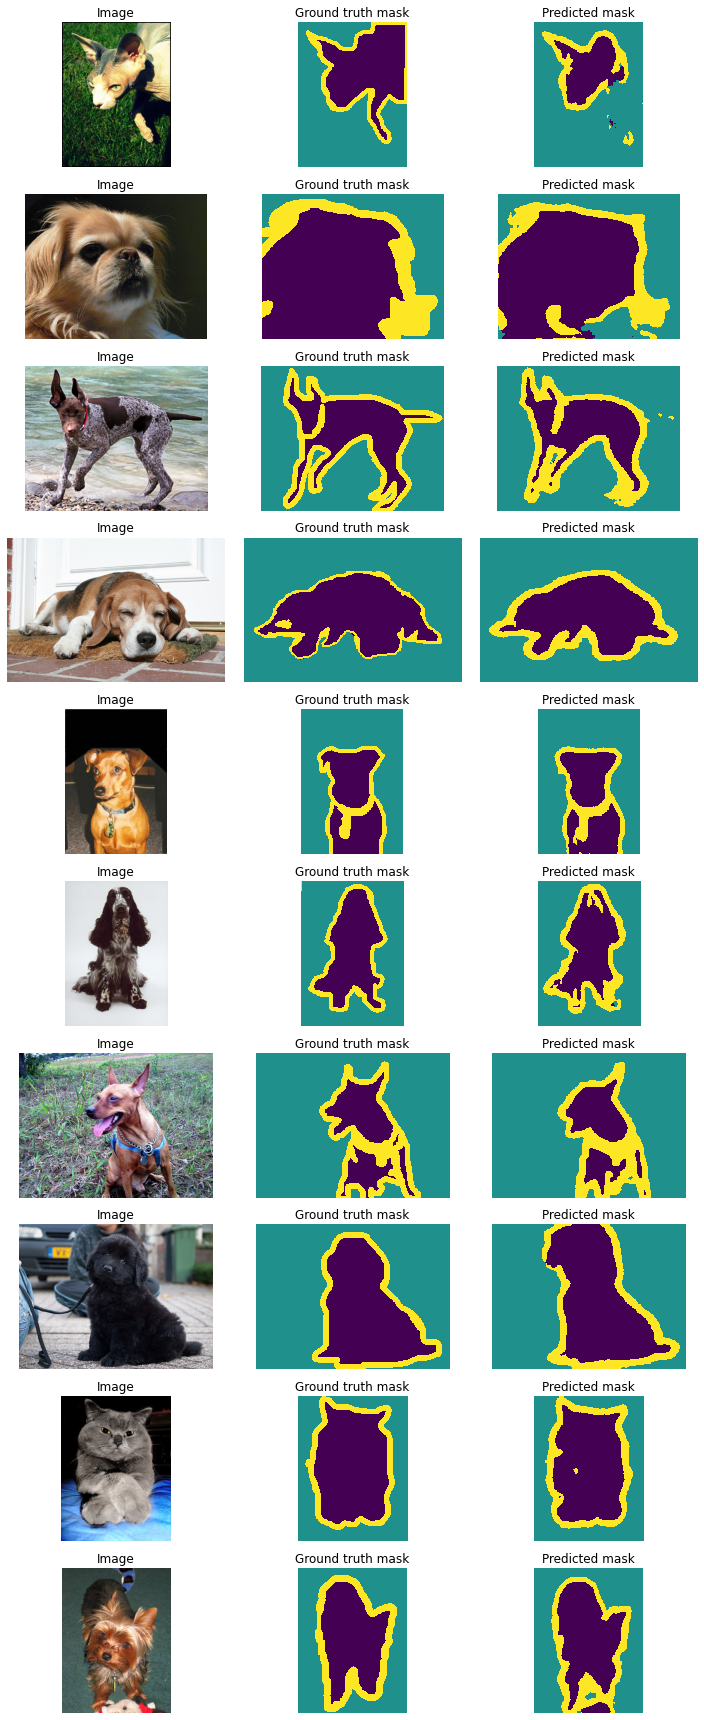

In [ ]:
display_image_grid(test_images_filenames[:10], images_directory, masks_directory, predicted_masks=predicted_masks)

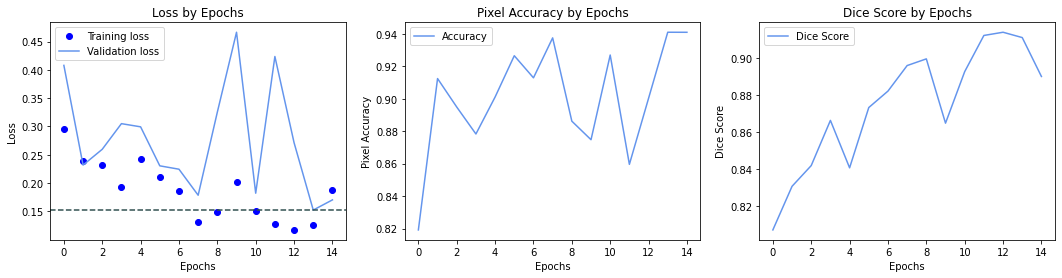

In [ ]:
# plot loss by epochs
   # create plots
plt.subplots(figsize=(18,4))
min_loss = np.min(history['end_val_loss'])
plt.subplot(1,3,1)
plt.plot(history['end_loss'], 'bo', label = 'Training loss')
plt.plot(history['end_val_loss'], 'cornflowerblue', label = 'Validation loss')
plt.title('Loss by Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
plt.legend()

# plot accuracy by epochs
plt.subplot(1,3,2)
plt.plot(history['end_val_correct'], 'cornflowerblue', label = 'Accuracy')
plt.title('Pixel Accuracy by Epochs')
plt.xlabel('Epochs')
plt.ylabel('Pixel Accuracy')
plt.legend()

# plot dice score by epochs
plt.subplot(1,3,3)
plt.plot(history['end_dice'], 'cornflowerblue', label = 'Dice Score')
plt.title('Dice Score by Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()